In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.1+cu116  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
''' 3. MNIST 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


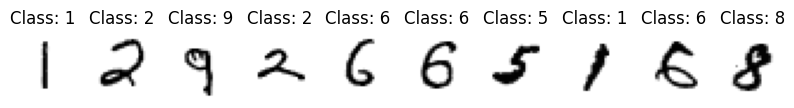

In [6]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 6. Multi Layer Perceptron (MLP) 모델 설계하기 '''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512) # 첫번째 레이어 : 이전 레이어(Input 레이어)의 노드 갯수 (28 * 28)와 현 레이어의 노드 개수(512) 정의
        self.fc2 = nn.Linear(512, 256) # 두번째 레이어
        self.fc3 = nn.Linear(256, 128) # 두번째 레이어
        self.fc4 = nn.Linear(128, 10) # 마지막 레이어

    def forward(self, x):
        x = x.view(-1, 28 * 28) # x를 (batch_size, 28 * 28)의 모양으로 만들어줌
        x = self.fc1(x) # 생성자 함수에서 정의한 레이어 통과
        x = F.leaky_relu(x) #sigmoid(x) # sigmoid 활성함수 통과
        x = self.fc2(x) # 생성자 함수에서 정의한 레이어 통과
        x = F.leaky_relu(x)#F.sigmoid(x) # sigmoid 활성함수 통과
        x = self.fc3(x) # 생성자 함수에서 정의한 레이어 통과
        x = F.leaky_relu(x)#F.sigmoid(x) # sigmoid 활성함수 통과
        x = self.fc4(x) # 생성자 함수에서 정의한 레이어 통과
        
        # 마지막으로 log_softmax 활성함수를 사용 -> softmax에 log를 취한 것과 동일
        # 두 연산을 따로 수행하는 것보다 더 빠름
        # 그냥 softmax에 의한 결과는 NLL Loss에 직접적으로 사용할 경우
        # 수치적으로 불안정해서 NaN의 결과를 얻을 수 있으므로, log_softmax와 NLL Loss를 결합하는 것을 추천
        x = F.log_softmax(x, dim = 1) # log
        return x

In [8]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = Net().to(DEVICE) # 정의한 네트워크를 DEVICE(GPU 혹은 CPU)에 올림
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9) # SGD with Momentum Optimizer 사용, 학습률 0.01, Momentum 0.5 (이전 스텝의 그래디언트 값에 곱해지는 factor)
# criterion = nn.CrossEntropyLoss() # CrossEntropyLoss에는 log softmax와 NLLloss가 포함되어 있음
criterion = nn.NLLLoss() # 따라서 위 처럼 log_softmax 사용했을 경우, NLLloss 사용, 마지막에 softmax 사용 안했으면 CrossEntropyLoss 사용

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() # gradient 0으로 초기화
        output = model(image)
        loss = criterion(output, label)
        loss.backward() # requires_grad=True인 모든 parameter에 대해 gradient 계산
        optimizer.step() # update 진행

        if batch_idx % log_interval == 0: # 지정한 log_interval 마다 아래 문구 출력
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

- max 예시



```
a = tensor([[-1.2360, -0.2942, -0.1222,  0.8475],
            [ 1.1949, -1.1127, -2.2379, -0.6702],
            [ 1.5717, -0.9207,  0.1297, -1.8768],
            [-0.6172,  1.0036, -0.6060, -0.2432]])
            
a.max(1)
torch.return_types.max(values=tensor([0.8475, 1.1949, 1.5717, 1.0036]), indices=tensor([3, 0, 0, 1]))

a.max(1, keepdim=True)
torch.return_types.max(values=tensor([[0.8475], [1.1949], [1.5717], [1.0036]]), indices=tensor([[3], [0], [0], [1]]))
```



In [10]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval() # dropout 같은 train과 val/test 상황에서 상태가 달라지는 레이어를 위해 사용
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1] # dim = 1 을 따라서 maximum 값들을 구함
            correct += prediction.eq(label.view_as(prediction)).sum().item() # label을 prediction과 같은 Tensor shape를 갖도록 만들어준뒤 이를 prediction과 비교하여 같은 것만 추출(.eq). sum()을 통해 일치하는 것들의 개수를 받고, 이를 python 숫자로 반환(.item())
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [11]:
''' 10. MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200) # 200 step마다 결과 출력
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.305994
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.853259
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.417734
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.405910
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.230914
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.160171
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.450933
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.135587
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.030503
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.065940

[EPOCH: 1], 	Test Loss: 0.1461, 	Test Accuracy: 95.52 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.057067
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.057430
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.041794
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.576624
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.144845
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.032665
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.014672
T